# LIBRARIES

In [1]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

# For timing computations
import time

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_26044/2891261325.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# DATASETS

## WINE DATASET

In [5]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')
# Remove rows with outliers
data = data[data['total sulfur dioxide']<200]

# Z-SCORE ALL VARIABLES EXCEPT FOR QUALITY
# Find the columns we want to normalize (all except quality)
cols_2_zscore = data.keys()
cols_2_zscore = cols_2_zscore.drop('quality')
data[cols_2_zscore] = data[cols_2_zscore].apply(stats.zscore)

# Create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# Data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality'] > 5] = 1

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_26044/984570066.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality'] > 5] = 1


# SEPARATE THE DATA INTO BATCHES

In [6]:
# Convert from pandas dataframe to tensor
dataT  = torch.tensor(data=data[cols_2_zscore].values).float()
labels = torch.tensor(data=data['boolQuality'].values).float()
labels = labels[:, None] # Transform to matrix. We'll actually need the labels to be a "tensor"

In [7]:
# Separate the data into DataLoaders
# Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size=0.1)

# Then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataset = TensorDataset(train_data, train_labels)
test_dataset  = TensorDataset(test_data, test_labels)

# Finally, translate into dataloader objects
train_batch_size = 32
test_batch_size  = test_dataset.tensors[0].shape[0]
train_loader     = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=True)
test_loader      = DataLoader(dataset=test_dataset, batch_size=test_batch_size)

# Now for the DL part

In [12]:
class ANN_wine_batch_norm(nn.Module):
  def __init__(self):
    super().__init__()

    # LAYERS
    # Input layer
    self.input = nn.Linear(11, 16)

    # Hidden layer(s). 'fc' = fully connected
    self.fc1      = nn.Linear(16, 32)
    self.b_norm_1 = nn.BatchNorm1d(num_features=16) # The number of units into this layer
    self.fc2      = nn.Linear(32, 20)
    self.b_norm_2 = nn.BatchNorm1d(num_features=32)

    # Output layer
    self.output = nn.Linear(20, 1)
  
  # Forward pass
  def forward(self, x, do_BN):
    # Input (x starts off normalized)
    x = F.relu(input=self.input(x))
    
    if do_BN:
      # Hidden layer 1
      x = self.b_norm_1(x)          # Batchnorm
      x = F.relu(input=self.fc1(x)) # Weighted combination + Activation function

      # Hidden layer 2
      x = self.b_norm_2(x)          # Batchnorm
      x = F.relu(input=self.fc2(x)) # Weighted combination + Activation function
    
    else:
      x = F.relu(input=self.fc1(x)) # Hidden layer 1
      x = F.relu(input=self.fc2(x)) # Hidden layer 2
    
    # Output layer
    x = self.output(x)

    return x

In [13]:
def create_a_new_model():

  # Grab an instance of the model class
  ANN_model = ANN_wine_batch_norm()

  # Loss function
  loss_func = nn.BCEWithLogitsLoss()

  # Optimizer
  optimizer = torch.optim.SGD(params=ANN_model.parameters(), lr=0.01)

  return ANN_model, loss_func, optimizer

# Train the model

In [14]:
# Global parameter
num_epochs = 1000

def train_the_model(do_BN = True):
  ANN_model, loss_func, optimizer = create_a_new_model()
  
  # Initialize accuracies as empties
  train_acc = []
  test_acc  = []
  losses = torch.zeros(num_epochs)

  # Loop over epochs
  for epoch_i in range(num_epochs):
    # Activate training mode
    ANN_model.train()

    # Loop over training data batches
    batch_acc = []
    batch_loss = []

    for X, y in train_loader:

      # Forward pass and loss
      y_hat = ANN_model(X, do_BN)
      loss  = loss_func(y_hat, y)

      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute training accuracy just for this batch
      batch_acc.append(100 * torch.mean(((y_hat > 0) == y).float()).item())

      # Loss from this batch
      batch_loss.append(loss.item())

    # End of batch loop...

    # Now that we've trained through the batches, get their average training accuracy 
    train_acc.append(np.mean(batch_acc))

    # Get average losses across the batches
    losses[epoch_i] = np.mean(batch_loss)

    # Test accuracy (NOTE: testing in batches!)
    # NOTE: Batch normalization should be turned off during testing, so we definitely need to switch modes here
    X, y = next(iter(test_loader))  # Extract x,y from test dataloader
    ANN_model.eval()                # Activate testing mode
    with torch.no_grad():           # Deactivates autograd
      pred_labels = ANN_model(X, do_BN)

    # Compute accuracy
    test_acc.append(100 * torch.mean(((pred_labels > 0) == y).float()).item())

  # Function output
  return train_acc, test_acc, losses

# Now for the experiment

In [15]:
# Create and train a model NO BATCHNORM
ANN_BN = ANN_wine_batch_norm()
train_acc_No, test_acc_No, losses_No = train_the_model(do_BN=False)

# Create and train a model WITH BATCHNORM
ANN_BN = ANN_wine_batch_norm()
train_acc_With, test_acc_With, losses_With = train_the_model(do_BN=True)

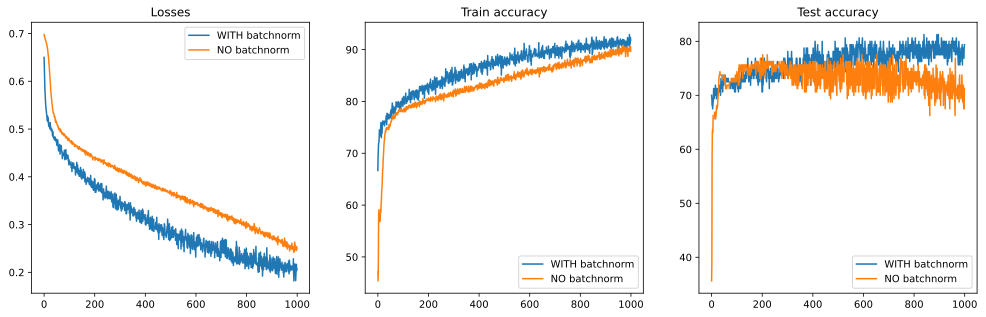

In [16]:
# PLOT THE RESULTS
fig, ax = plt.subplots(1, 3, figsize=(17, 5))

ax[0].plot(losses_With, label='WITH batchnorm')
ax[0].plot(losses_No, label='NO batchnorm')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(train_acc_With, label='WITH batchnorm')
ax[1].plot(train_acc_No, label='NO batchnorm')
ax[1].set_title('Train accuracy')
ax[1].legend()

ax[2].plot(test_acc_With, label='WITH batchnorm')
ax[2].plot(test_acc_No, label='NO batchnorm')
ax[2].set_title('Test accuracy')
ax[2].legend()

plt.show()

# Additional explorations
1) BatchNorm1d takes several additional inputs, including one called "momentum." You will learn what this parameter
   means later in this section, but briefly: it is a smoothing parameter that helps stabilize and improve learning
   weights. The default value is .1. What happens when you change it to .001? How about setting it to zero?

2) In the lecture, I said to apply batchnorm to the data *before* applying the nonlinearity (here, relu). This is also
   implemented in the code above. However, this is discussed in the field and online, and not everyone agrees. Modify 
   the code to apply batch normalization *after* applying relu. Does that make a big difference? Thinking about the
   math, which order makes more sense to you? (Don't worry, it's OK to disagree with me!)